## Importing packages and functions

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import copy
warnings.simplefilter("ignore")

## Loading data

In [2]:
X1 = pd.read_csv("data/X1.csv")
X2 = pd.read_csv("data/X2.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])

## Preprocessing the data
### removing unused features

In [3]:
X = X1.drop(['Unnamed: 0', 'img_url', 'description', 'is_adult'], axis=1)

### Preprocessing functions for each used feature

In [4]:
"""
Defining the training and testing set sizes
"""
n_samples = X.shape[0]
n_samples2 = X2.shape[0]

In [5]:
"""
Keeping the directly usable features
"""
def get_directrly_usable_features(df, df2 = None):
    """
    return df completed with the directly usable features (described in the report) for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2
    """
    directly_usable_features = ["ratings", "n_votes"]
    for feature in directly_usable_features:
        if df2 is not None :
            df2[feature] = X2[feature]
        df[feature] = X[feature]
    if df2 is None:
      return df
    return df, df2

In [6]:
"""
Dealing with the "production_year" feature
"""

def get_prod_year_feature(df, params, df2 = None):
    """
    return df completed preprocessed prod_year and release_year features for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The possible preprocessing params are described in the report.
    """
    style = params["production_year_style"] # "per_quantile" / "per_period_length" / "no_period"
    if style != "no_period" :
        n_year_period = params["n_year_period"]

    # Removing previously computed categorie(s) for the "production_year" initial feature

    for feature in df.columns:
        if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "production_year" initial feature

    prod_year = X["production_year"].copy()
    prod_year2 = X2["production_year"].copy()
    if style == "per_quantile" or style == "per_period_length":
        categories = np.ones((n_year_period, n_samples))
        if df2 is not None :
            categories2 = np.ones((n_year_period, n_samples2))
        if style == "per_quantile":
            thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
        else :
            thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
        for i, threshold in enumerate(thresholds):
            categories[i+1] = (prod_year >= threshold).astype(int)
            categories[i] -= categories[i+1]
            if df2 is not None :
                categories2[i+1] = (prod_year2 >= threshold).astype(int)
                categories2[i] -= categories2[i+1]
        for period in range(n_year_period):
            df["period {}".format(period)] = categories[period]
            if df2 is not None :
                df2["period {}".format(period)] = categories2[period]
    elif style == "no_period":
        df["production_year"] = prod_year
        if df2 is not None:
            df2["production_year"] = prod_year2
    rel_year = X["release_year"].copy()
    rel_year2 = X2["release_year"].copy()
    if style == "per_quantile" or style == "per_period_length":
        categories = np.ones((n_year_period, n_samples))
        if df2 is not None :
            categories2 = np.ones((n_year_period, n_samples2))
        if style == "per_quantile":
            thresholds = rel_year.quantile(np.arange(1, n_year_period) / n_year_period)
        else :
            thresholds = np.min(rel_year) + (np.max(rel_year) - np.min(rel_year))*np.arange(1, n_year_period)/n_year_period
        for i, threshold in enumerate(thresholds):
            categories[i+1] = (rel_year >= threshold).astype(int)
            categories[i] -= categories[i+1]
            if df2 is not None :
                categories2[i+1] = (rel_year2 >= threshold).astype(int)
                categories2[i] -= categories2[i+1]
        for period in range(n_year_period):
            df["period_r {}".format(period)] = categories[period]
            if df2 is not None :
                df2["period_r {}".format(period)] = categories2[period]
    elif style == "no_period":
        df["release_year"] = rel_year
        if df2 is not None:
            df2["release_year"] = rel_year2
    
    if df2 is None:
      return df
    return df, df2

In [7]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

def get_runtime_feature(df, params, df2 = None):
    """
    return df completed preprocessed runtime feature for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The possible preprocessing params are described in the report.
    """
    replace_type = params["runtime_replace_type"] # "zero" / "mean" / "median"

    if df2 is not None:
        runtime2 = X2["runtime"].copy()

    runtime = X["runtime"].copy()
    if replace_type == "zero":
        runtime[runtime == "\\N"] = 0
        if df2 is not None:
            runtime2[runtime2 == "\\N"] = 0
    if replace_type == "mean":
        mean = np.mean(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = mean
        if df2 is not None:
            runtime2[runtime2 == "\\N"] = mean
    if replace_type == "median":
        median = np.median(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = median
        if df2 is not None:
            runtime2[runtime2 == "\\N"] = median
    df["runtime"] = runtime.astype(float)    
    if df2 is not None:
        df2["runtime"] = runtime2.astype(float)
    if df2 is None:
      return df
    return df, df2

In [8]:
"""
Dealing with the "studio" feature
"""

def get_studio_feature(df, params, df2 = None):
    """
    return df completed preprocessed studio feature for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The possible preprocessing params are described in the report.
    """
    use_PCA = params["studio_use_PCA"]
    if use_PCA :
        dim = params["studio_PCA_dim"]

    # Removing previously computed categorie(s) for the "studio" initial feature
    for feature in df.columns:
        if len(feature) >= 10 and feature[:10] == "studio_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "studio" initial feature
    studio = copy.deepcopy(X["studio"])
    studio_labels = np.unique(studio)
    studio_features = np.zeros((len(studio_labels), n_samples))
    for i, label in enumerate(studio_labels) :
        studio_features[i] = (studio == label).astype(int)

    if df2 is not None:
        studio2 = copy.deepcopy(X2["studio"])
        studio_features2 = np.zeros((len(studio_labels), n_samples2))
        for i, label in enumerate(studio_labels) :
            studio_features2[i] = (studio2 == label).astype(int)

    # Applying pca or not
    if use_PCA :
        pca = PCA(n_components=dim)
        out = pca.fit_transform(studio_features.T)
    else :
        normals = studio_features[np.count_nonzero(studio_features, axis=1) > 5].T
        outliers = np.sum(studio_features[np.count_nonzero(studio_features, axis=1) <= 5].T, axis = 1)
        out = np.zeros((normals.shape[0], normals.shape[1] + 1))
        out[:, :-1] = normals
        out[:, -1] = outliers
        dim = out.shape[1]
        if df2 is not None :
            normals2 = studio_features2[np.count_nonzero(studio_features, axis=1) > 5].T
            outliers2 = np.sum(studio_features2[np.count_nonzero(studio_features, axis=1) <= 5].T, axis = 1)
            out2 = np.zeros((normals2.shape[0], normals2.shape[1] + 1))
            out2[:, :-1] = normals2
            out2[:, -1] = outliers2

    df[["studio_PC_{}".format(i) for i in range(dim)]] = out
    if df2 is not None:
        df2[["studio_PC_{}".format(i) for i in range(dim)]] = out2
    if df2 is None:
      return df
    return df, df2

In [9]:
"""
Dealing with the "genres" feature
"""

def get_genre_feature(df, df2 = None):
    """
    return df completed preprocessed genre feature for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The preprocessing explanation stands on the report.
    """
    X.loc[X["genres"] == "\\N", "genres"] = "Others"
    X2.loc[X2["genres"] == "\\N", "genres"] = "Others"
    all_genres = X["genres"].copy()
    if df2 is not None:
        all_genres2 = X2["genres"].copy()
    diff_genres = []

    for genres in np.unique(all_genres):
        for genre in genres.split(",") :
            if not genre in diff_genres :
                diff_genres.append(genre)

    for genre in diff_genres:
        df[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]  
        if df2 is not None:
            df2[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres2]  
    if df2 is None:
      return df
    return df, df2

In [10]:
"""
Dealing with the "text_embeddings" feature
"""
def get_text_embedding_feature(df, params, df2 = None):
    """
    return df completed preprocessed text embedding feature for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The possible preprocessing params are described in the report.
    """
    
    output_dim = params["text_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "text_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "text_embedding" initial feature
    text_embeddings = X["text_embeddings"]
    
    input_dim = 768
    embeddings = np.zeros((n_samples, input_dim))
    for i, text_embedding in enumerate(text_embeddings):
        embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))
    if df2 is not None:
        text_embeddings2 = X2["text_embeddings"]
        embeddings2 = np.zeros((n_samples2, input_dim))
        for i, text_embedding in enumerate(text_embeddings2):
            embeddings2[i] = list(map(float,text_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)
    df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

    if df2 is not None :
        output2 = pca.transform(embeddings2)
        df2[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output2
    if df2 is None:
      return df
    return df, df2

In [11]:
"""
Dealing with the "img_embeddings" feature
"""
def get_img_embedding_feature(df, params, df2 = None):
    """
    return df completed preprocessed img embedding feature for the training data, X1 
    if df2 is not None, does the same for df2 and the testing data, X2

    The possible preprocessing params are described in the report.
    """
    output_dim = params["img_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "img_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "img_embedding" initial feature
    img_embeddings = X["img_embeddings"]
    input_dim = 2048
    embeddings = np.zeros((n_samples, input_dim))
    for i, img_embedding in enumerate(img_embeddings):
        embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

    if df2 is not None:
        img_embeddings2 = X2["img_embeddings"]
        embeddings2 = np.zeros((n_samples2, input_dim))
        for i, img_embedding in enumerate(img_embeddings2):
            embeddings2[i] = list(map(float,img_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)
    if df2 is not None :
        output2 = pca.transform(embeddings2)
        df2[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output2
    df[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

    if df2 is None:
      return df
    return df, df2

## complete preprocessing functions

In [12]:
def create_preprocessed(params, preprocess_X2 = False):
    """
    returns a fully preprocessed dataset according to the chosen params and from the training set (X2).

    if preprocess_X2 is set to True, it also returns the test set, X2 dataset, preprocessed on the same way.
    """
    if preprocess_X2 == False :
        df = pd.DataFrame()
        df = get_genre_feature(df)
        df = get_directrly_usable_features(df)
        df = get_prod_year_feature(df, params)
        df = get_studio_feature(df, params)
        df = get_runtime_feature(df, params)
        df = get_text_embedding_feature(df, params)
        df = get_img_embedding_feature(df, params)
    else :
        df, df2 = pd.DataFrame(), pd.DataFrame()
        df, df2 = get_genre_feature(df, df2)
        df, df2 = get_directrly_usable_features(df, df2)
        df, df2 = get_prod_year_feature(df, params, df2)
        df, df2 = get_studio_feature(df, params, df2)
        df, df2 = get_runtime_feature(df, params, df2)
        df, df2 = get_text_embedding_feature(df, params, df2)
        df, df2 = get_img_embedding_feature(df, params, df2)
    if preprocess_X2 == False:
      return df
    return df, df2

In [13]:
"""
In order to not have to recalculate the full preprocessing of the data at each step of our local search algorithm,
we implemented a way to compute a dictionnary containing the multiple preprocessing possibilities for each feature
that you want to test. This way, you can create this dictionnary once at the beginning of the local search algorithm
and then reuse it at each iteration.
"""

def create_preprocessed_dict(params):
    """
    returns a dictionnary containing multiple versions of the X2 preprocessed dataset.
    These different preprocessings are chosen with params.
    """
    final = {}
    year_dict = {}
    for val1 in params["production_year_style"] :
        for val2 in params["n_year_period"] :
            tmp = {}
            tmp["production_year_style"] = val1
            tmp["n_year_period"] = val2
            year_dict[val1+str(val2)] = get_prod_year_feature(pd.DataFrame(), tmp)
    final["year"] = year_dict
    
    studio_dict = {}
    for val1 in params["studio_use_PCA"] :
        for val2 in params["studio_PCA_dim"] :
            tmp = {}
            tmp["studio_use_PCA"] = val1
            tmp["studio_PCA_dim"] = val2
            studio_dict[str(val1)+str(val2)] = get_studio_feature(pd.DataFrame(), tmp)
    final["studio"] = studio_dict
    
    runtime_dict = {}
    for val in params["runtime_replace_type"] :
        tmp = {}
        tmp["runtime_replace_type"] = val
        runtime_dict[val] = get_runtime_feature(pd.DataFrame(), tmp)
    final["runtime"] = runtime_dict
    
    text_dict = {}
    for val in params["text_embedding_PCA_dim"] :
        tmp = {}
        tmp["text_embedding_PCA_dim"] = val
        text_dict[val] = get_text_embedding_feature(pd.DataFrame(), tmp)
    final["text"] = text_dict
    
    img_dict = {}
    for val in params["img_embedding_PCA_dim"] :
        tmp = {}
        tmp["img_embedding_PCA_dim"] = val
        img_dict[val] = get_img_embedding_feature(pd.DataFrame(), tmp)
    final["img"] = img_dict   
    final["genre"] = get_genre_feature(pd.DataFrame())
    final["base"] = get_directrly_usable_features(pd.DataFrame())
    return final

In [14]:
def create_preprocessed_from_dict(params_dict, params):
    """
    returns the preprocessed dataset created from a precomputed dictionnary of preprocessed data options, params_dict and a specific wanted preprocessing, params.
    """
    frames = []
    frames.append(params_dict["genre"])
    frames.append(params_dict["base"])
    frames.append(params_dict["year"][params["production_year_style"] + str(params["n_year_period"])])
    frames.append(params_dict["studio"][str(params["studio_use_PCA"]) + str(params["studio_PCA_dim"])])
    frames.append(params_dict["runtime"][params["runtime_replace_type"]])
    frames.append(params_dict["text"][params["text_embedding_PCA_dim"]])
    frames.append(params_dict["img"][params["img_embedding_PCA_dim"]])
    return pd.concat(frames, axis=1)

## Examples of preprocessing

In [15]:
# Note that the studio_use_PCA and studio_PCA_dim are here useless since we finally did not use PCA on it (it was not really making any sense)

all_params = {
    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : [3, 5, 10],
    "runtime_replace_type" : ["mean", "zero"], # "mean" / "zero" / "median"
    "studio_use_PCA" : [False],
    "studio_PCA_dim" : [1, 10],
    "text_embedding_PCA_dim" : [1, 10],
    "img_embedding_PCA_dim" : [1, 10]
}

params = {
    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "mean", # "mean" / "zero"
    "studio_use_PCA" : False,
    "studio_PCA_dim" : 1,
    "text_embedding_PCA_dim" : 10,
    "img_embedding_PCA_dim" : 10
}

preprocessed_dict = create_preprocessed_dict(all_params)
preprocessed_data = create_preprocessed_from_dict(preprocessed_dict, params)
preprocessed_data_2 = create_preprocessed(params)

# checking that the two preprocessed datasets features are equivalent
for i in range(len(preprocessed_data.columns)):
    assert preprocessed_data.columns[i] == preprocessed_data_2.columns[i]

# Defining our loss function


In [16]:
# Score computation : Root Mean Square Error

def compute_rmse(predict, target):
    return -mean_squared_error(predict, target, squared=False)

def compute_rmse2(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return -float(rmse)

custom_scorer = make_scorer(compute_rmse)

# Optimizing the model parameters

## Our homemade mixed localsearch + randomizedsearch algorithm for the preprocessing parameters

The method we used to try getting the best regressor is to use a Localsearch algorithm parsing among the above defined preprocessing parameters. For each possible preprocessing, the algorithm performs a RandomizedSearch 5-fold cross validation to select the best parameters of the given regressor. The possible values for each preprocessing and regressor parameter has to be given as imput to the algorithm.

NB : You might want to reduce the thresholds for $\texttt{no_reduce}$ in the $\texttt{compute}$ function if performing the gridsearch on the most time consuming regressors to fit(by choosing a small value of $\texttt{max_no_upgrade}$).

In [17]:
class Solution:
    def __init__(self, params, grid_params, score, RSCV):
        self.grid_params = grid_params
        self.params = params
        self.score = score
        self.RSCV = RSCV

class LocalSearch :
    
    def __init__(self, regressor, params, grid_params, max_no_upgrade):
        self.curr_score = []
        self.best_score = []
        self.regressor = regressor
        self.params = params
        self.preprocessed_dict = create_preprocessed_dict(params)
        self.grid_params = grid_params
        self.visited = []
        self.max_no_upgrade = max_no_upgrade

    
    def clean(self, params):
        copied = copy.deepcopy(params)
        if copied["production_year_style"] == "no_period":
            copied.pop("n_year_period")
        if copied["studio_use_PCA"] == False:
            copied.pop("studio_PCA_dim")
        return copied
    
    def is_visited(self, params):
        return str(self.clean(params)) in self.visited
    
    def visit(self, params):
        self.visited.append(str(self.clean(params)))
    
    def get_solution(self, params):
        preprocessed_data = copy.deepcopy(create_preprocessed_from_dict(self.preprocessed_dict, params))
        RSCV = RandomizedSearchCV(regressor, self.grid_params, cv=5, scoring=custom_scorer, n_jobs=-1, random_state=0)
        RSCV.fit(preprocessed_data, Y1)
        current_score = np.mean(RSCV.best_score_)
        self.visit(params)
        return Solution(params, RSCV.best_params_, current_score, RSCV)
    
    def initiate(self):
        current_params = {}
        for param in self.params.keys():
            current_params[param] = np.random.choice(self.params[param])
        self.current_solution = self.get_solution(current_params)
        self.best_solution = copy.deepcopy(self.current_solution)
    
    def transitions(self):
        neighbors = []
        current_params = self.current_solution.params
        for param in self.params.keys():
            copied = copy.deepcopy(self.params[param])
            np.random.shuffle(copied)
            for value in copied:
                new_params = copy.deepcopy(current_params)
                new_params[param] = value
                if not self.is_visited(new_params):
                    neighbors.append(new_params)
                    break
        return neighbors
    
    def choose(self, neighbors, n):
        if len(neighbors) <= n :
            return neighbors
        return np.random.choice(neighbors, size=n, replace = False)
    
    def get_difference(self, other):
        first = self.current_solution.params
        for param in first.keys():
            if first[param] != other[param]:
                return param, first[param], other[param]
        return None
    
    def compute(self):
        """
        executing the local search algorithm

        This local search algorithm is a basic implementation, it does not contain advanced optimizations such as
        resets or tabu-search.
        """
        self.initiate()
        print("INITIALISATION ENDED : initial score of {:.2e} $".format(self.best_solution.score))
        no_upgrade = 0;
        while no_upgrade <= self.max_no_upgrade:
            neighbors = self.transitions()
            if len(neighbors) == 0:
                break
            neighbors = self.choose(neighbors, 5)
            curr_best_sol = Solution(None, None, -float("inf"), None)
            for neighbor in neighbors :
                solution = self.get_solution(neighbor)
                if solution.score > curr_best_sol.score :
                    curr_best_sol = solution
                diff = self.get_difference(neighbor)
                # print("{} : {} -> {} score {:.2%}".format(diff[0], diff[1], diff[2],solution.score))
            self.current_solution = copy.deepcopy(curr_best_sol)
            # print("updated current")
            if curr_best_sol.score > self.best_solution.score:
                self.best_solution = copy.deepcopy(curr_best_sol)
                print("SOLUTION UPGRADED : new score of {:.2e} $".format(self.best_solution.score))
                no_upgrade = 0

            self.curr_score.append(self.current_solution.score)
            self.best_score.append(self.best_solution.score)
            no_upgrade += 1

## Some nice printing and plotting functions for the results

In [18]:
def print_solution(regressor, solution):
    print(f"The {regressor} Regressor reaches mean RMSE of {-solution.score:.4e} $.")
    var = solution.RSCV.cv_results_['std_test_score'][solution.RSCV.best_index_]
    print(f"This RMSE has a variance of {var:.4e}")
    data = [["PARAMETER", "VALUE"]] + [[key, solution.params[key]] for key in solution.params.keys()]
    col_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]
    print("\nPreprocessing :")
    for row in data:
        print(' '.join(str(cell).ljust(col_widths[i]) for i, cell in enumerate(row)))

    data = [["PARAMETER", "VALUE"]] + [[key, solution.grid_params[key]] for key in solution.grid_params.keys()]
    col_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]
    print("\nRegressor :")
    for row in data:
        print(' '.join(str(cell).ljust(col_widths[i]) for i, cell in enumerate(row)))

In [19]:
def print_evolution(LS, name):
    current_scores = np.array(LS.curr_score)
    best_scores = np.array(LS.best_score)
    iter = np.arange(1, len(current_scores)+1)
    plt.plot(iter, -current_scores, label="current solution", color="blue", linestyle="--")
    plt.plot(iter, -best_scores, label="best solution", color="red")
    plt.title("Local search score evolution", fontsize=20)
    plt.ylabel("avg RMSE on 5-fold")
    plt.xlabel("iter")
    plt.legend()
    plt.grid()
    plt.savefig(f"LS{name}.png")
    plt.show()

def print_last_RSCV_evolution(solution, name):
    RSCV = solution.RSCV
    RMSE = RSCV.cv_results_['mean_test_score']
    # Plot the scores as a function of the iteration
    plt.plot(range(1, len(RMSE)+1), -RMSE)
    plt.xlabel('iter')
    plt.ylabel('RMSE')
    plt.title("Randomized search score evolution")
    plt.grid()
    plt.savefig(f"RSCV{name}.png")
    plt.show()

## Choosing our preprocessing parameters possibilities for the optimization

In [20]:
preprocessing_params = {
    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : [3, 5, 10],
    "runtime_replace_type" : ["mean", "zero", "median"], # "mean" / "zero" / "median"
    "studio_use_PCA" : [False],
    "studio_PCA_dim" : [10], # this parameter has no use since we finally do not use PCA on the studio feature
    "text_embedding_PCA_dim" : [1, 10, 20, 50, 100],
    "img_embedding_PCA_dim" : [1, 10, 20, 50, 100]
}

## Optimizing an OLS Regressor

In [21]:
regressor_params = {
    "fit_intercept": [False] # Set any parameter for the RandomizedSearch to work even if no preprocessing parameter is important.
}

max_no_upgrade = 20
regressor = LinearRegression()
LSOLS = LocalSearch(regressor, preprocessing_params, regressor_params, max_no_upgrade)
LSOLS.compute()

INITIALISATION ENDED : initial score of -5.64e+07 $
SOLUTION UPGRADED : new score of -5.63e+07 $
SOLUTION UPGRADED : new score of -5.62e+07 $
SOLUTION UPGRADED : new score of -5.61e+07 $


In [22]:
solution = LSOLS.best_solution
print_solution("OLS", solution)

The OLS Regressor reaches mean RMSE of 5.6128e+07 $.
This RMSE has a variance of 5.0750e+06

Preprocessing :
PARAMETER              VALUE            
production_year_style  per_period_length
n_year_period          3                
runtime_replace_type   zero             
studio_use_PCA         False            
studio_PCA_dim         10               
text_embedding_PCA_dim 100              
img_embedding_PCA_dim  1                

Regressor :
PARAMETER     VALUE
fit_intercept False


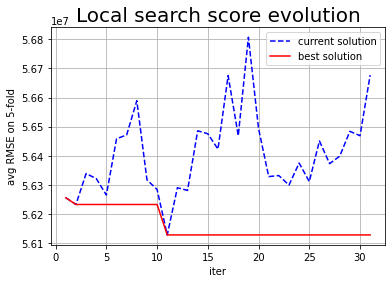

In [23]:
print_evolution(LSOLS, "OLS")
# print_last_RSCV_evolution(solution, "OLS") # this plot is useless since no parameter optimisation has to be done for OLS

## Optimizing a Ridge Regressor

In [24]:
regressor_params = {
    "alpha": [1e-1, 5e-1, 1, 5, 10, 20]
}

regressor = Ridge()
max_no_upgrade = 20
LSRidge = LocalSearch(regressor, preprocessing_params, regressor_params, max_no_upgrade)
LSRidge.compute()

INITIALISATION ENDED : initial score of -5.62e+07 $
SOLUTION UPGRADED : new score of -5.59e+07 $
SOLUTION UPGRADED : new score of -5.56e+07 $
SOLUTION UPGRADED : new score of -5.54e+07 $
SOLUTION UPGRADED : new score of -5.54e+07 $


In [25]:
solution = LSRidge.best_solution
print_solution("Ridge", solution)

The Ridge Regressor reaches mean RMSE of 5.5354e+07 $.
This RMSE has a variance of 5.9512e+06

Preprocessing :
PARAMETER              VALUE            
production_year_style  per_period_length
n_year_period          3                
runtime_replace_type   zero             
studio_use_PCA         False            
studio_PCA_dim         10               
text_embedding_PCA_dim 100              
img_embedding_PCA_dim  1                

Regressor :
PARAMETER VALUE
alpha     5    


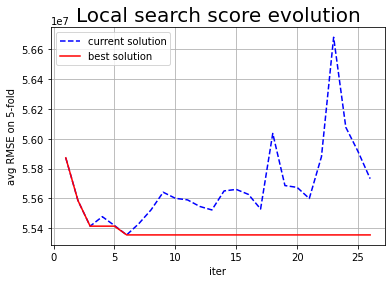

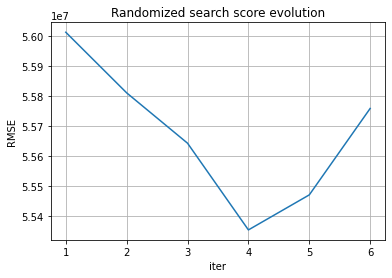

In [26]:
print_evolution(LSRidge, "Ridge")
print_last_RSCV_evolution(solution, "Ridge")

## Optimizing a KNN regressor

In [27]:
regressor_params = {
    'n_neighbors' : [2, 5, 10, 20, 50], 
    'weights' : ['uniform', 'distance']
}

max_no_upgrade = 20
regressor = KNeighborsRegressor()
LSKNN = LocalSearch(regressor, preprocessing_params, regressor_params, max_no_upgrade)
LSKNN.compute()

INITIALISATION ENDED : initial score of -6.11e+07 $
SOLUTION UPGRADED : new score of -6.10e+07 $
SOLUTION UPGRADED : new score of -6.10e+07 $
SOLUTION UPGRADED : new score of -6.10e+07 $
SOLUTION UPGRADED : new score of -6.10e+07 $
SOLUTION UPGRADED : new score of -6.10e+07 $


In [28]:
solution = LSKNN.best_solution
print_solution("KNN", solution)

The KNN Regressor reaches mean RMSE of 6.0987e+07 $.
This RMSE has a variance of 5.4322e+06

Preprocessing :
PARAMETER              VALUE       
production_year_style  per_quantile
n_year_period          3           
runtime_replace_type   zero        
studio_use_PCA         False       
studio_PCA_dim         10          
text_embedding_PCA_dim 20          
img_embedding_PCA_dim  1           

Regressor :
PARAMETER   VALUE  
weights     uniform
n_neighbors 10     


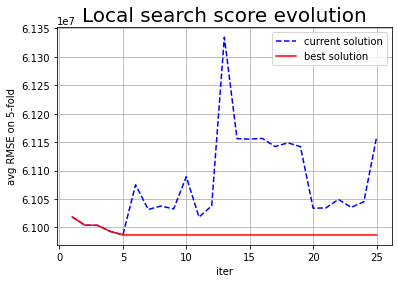

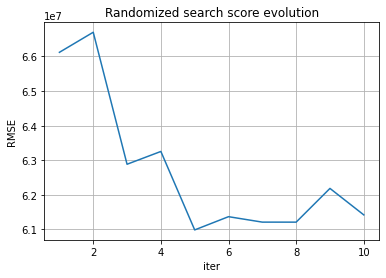

In [29]:
print_evolution(LSKNN, "KNN")
print_last_RSCV_evolution(solution, "KNN")

## Optimizing a Random Forest regressor

In [32]:
regressor_params = {
    "n_estimators": [50, 100, 200], 
    "criterion": ["squared_error"], # ["squared_error", "absolute_error", "poisson"],
    "min_samples_split": [1.0, 3],     # [1, 2, 3],
    "max_features" : ["sqrt", "log2"],      # ["sqrt", "log2", None]
}

max_no_upgrade = 10
regressor = RandomForestRegressor(n_jobs=-1,random_state=0)
LSRF = LocalSearch(regressor, preprocessing_params, regressor_params, max_no_upgrade)
LSRF.compute()

INITIALISATION ENDED : initial score of -5.76e+07 $
SOLUTION UPGRADED : new score of -5.45e+07 $
SOLUTION UPGRADED : new score of -5.43e+07 $
SOLUTION UPGRADED : new score of -5.30e+07 $


In [33]:
solution = LSRF.best_solution
print_solution("Random Forest", solution)

The Random Forest Regressor reaches mean RMSE of 5.2972e+07 $.
This RMSE has a variance of 5.7559e+06

Preprocessing :
PARAMETER              VALUE    
production_year_style  no_period
n_year_period          3        
runtime_replace_type   zero     
studio_use_PCA         False    
studio_PCA_dim         10       
text_embedding_PCA_dim 1        
img_embedding_PCA_dim  1        

Regressor :
PARAMETER         VALUE        
n_estimators      100          
min_samples_split 3            
max_features      sqrt         
criterion         squared_error


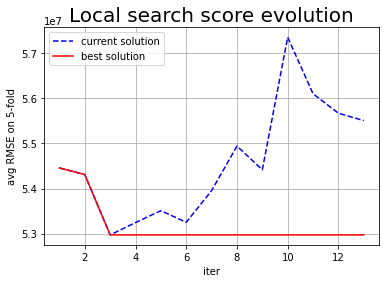

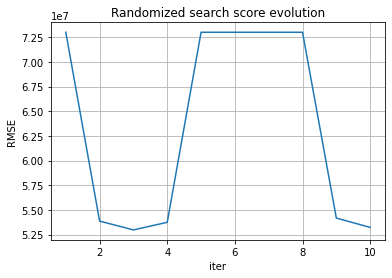

In [34]:
print_evolution(LSRF, "RF")
print_last_RSCV_evolution(solution, "RF")

## Our own MLP implementation with torch

In [35]:
# these parameters are the ones found for the best RF regressor in the report. 
preprocessing_params = {
    "production_year_style" : "no_period", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "zero", # "mean" / "zero" / "median"
    "studio_use_PCA" : False,
    "studio_PCA_dim" : None,
    "text_embedding_PCA_dim" : 1,
    "img_embedding_PCA_dim" : 1
}

X_train, X_test, y_train, y_test = train_test_split(create_preprocessed(preprocessing_params), Y1, test_size=0.2, random_state=0)

In [36]:
"""
Creating and training our MLP model
"""

import torch
from torch.utils.data import DataLoader

input_size = len(X_train.columns)
output_size = 1

hidden_layer_size = 50 # can be chosen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, output_size)
).to(device)
model = model.double()
loss_fn = torch.nn.MSELoss()

lr = 1e-2
betas = (0.7, 0.95)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

num_epochs = 30
batch_size = 16

inputs = X_train.to_numpy()
targets = y_train.to_numpy()
inputs = torch.from_numpy(inputs).to(device).double()
targets = torch.from_numpy(targets).to(device).double()
dataloader = DataLoader(list(zip(inputs, targets)), batch_size=batch_size, shuffle=True)

inputs_test = X_test.to_numpy()
targets_test = y_test.to_numpy()
inputs_test = torch.from_numpy(inputs_test).to(device).double()
targets_test = torch.from_numpy(targets_test).to(device).double()

train_RMSE = []
test_RMSE = []


for epoch in range(num_epochs):
    train_loss = []
    for inputs_batch, targets_batch in dataloader:
        outputs = model.forward(inputs_batch)
        loss = loss_fn(outputs, targets_batch)
        train_loss.append(loss * len(inputs_batch)) # we have to ponderate the loss according to the size of the batch since the last batch does not always have the same size as the others
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    toAdd = torch.sqrt(sum(train_loss)/len(inputs))
    train_RMSE.append(toAdd.cpu().detach().numpy())

    outputs = model.forward(inputs_test)
    err = (outputs - targets_test)
    test_loss = torch.sqrt(torch.sum(err*err) / len(err))
    test_RMSE.append(test_loss.cpu().detach().numpy())

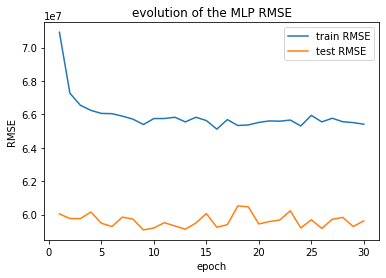

In [37]:
"""
Plotting the RMSE evolution of our training
"""

plt.plot(np.arange(1, num_epochs+1), train_RMSE, label="train RMSE")
plt.plot(np.arange(1, num_epochs+1), test_RMSE, label="test RMSE")
plt.title("evolution of the MLP RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("lr1e-2beta07095lay2dim50")
plt.show()

## creating the Y2 file with the best Regressor we found

In [38]:
best = LSRF # We here decided that the best model was the RandomForestRegressor regarding the previous results
solution = LSRF.best_solution
preprocessing_params = solution.params
regressor_params = solution.grid_params

preprocessed_data, preprocessed_X2 = create_preprocessed(preprocessing_params, preprocess_X2=True)
regressor = RandomForestRegressor(n_jobs=-1,random_state=0, **regressor_params)
regressor.fit(preprocessed_data, Y1)
estimated_RMSE = -solution.score

Y2 = regressor.predict(preprocessed_X2)
with open("Y2.csv", "w") as file:
    for target in Y2:
        file.write(str(target) + "\n")
    file.write(str(estimated_RMSE))